In [151]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.table import Table, join, Column
from astropy.stats import LombScargle
import astropy.units as u                          # We'll need this later.

from astropy.io import ascii
import glob, re, copy

from lightkurve import KeplerLightCurveFile, KeplerLightCurve

% matplotlib inline

import matplotlib as mpl
mpl.style.use('seaborn-colorblind')

#To make sure we have always the same matplotlib settings
#(the ones in comments are the ipython notebook settings)

mpl.rcParams['figure.figsize']=(12.0,9.0)    #(6.0,4.0)
mpl.rcParams['font.size']=20               #10 
mpl.rcParams['savefig.dpi']= 200             #72 
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
from matplotlib import rc

colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']


In [201]:
lcs = KeplerLightCurveFile.from_archive(8197761,quarter='all',cadence='long')
for j, lci in enumerate(lcs):
    lci = lci.get_lightcurve('PDCSAP_FLUX').remove_nans()
    lci = lci[lci.quality==0]
    lcs[j] = lci.normalize()

lc = lcs[0]
for lci in lcs[1:]:
    lc = lc.append(lci)

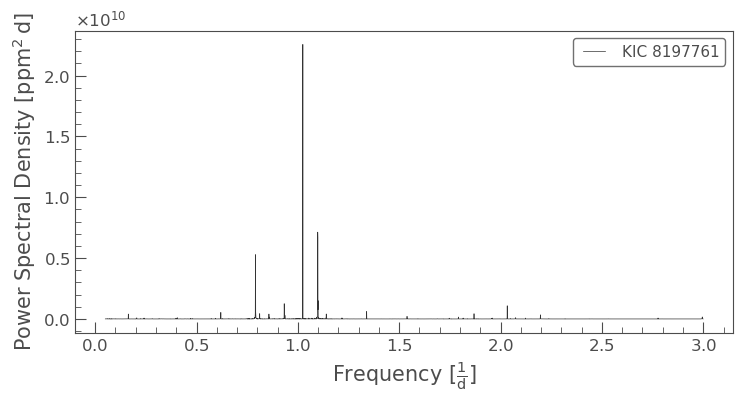

In [202]:
pg = lc.to_periodogram(min_period=8./24.*u.day, max_period=20.*u.day)
pg.plot();


In [203]:
y_fit = LombScargle(lc.time, lc.flux, lc.flux_err).model(lc.time, pg.frequency_at_max_power.value)

(120.53833690600732, 170.53833690600732)

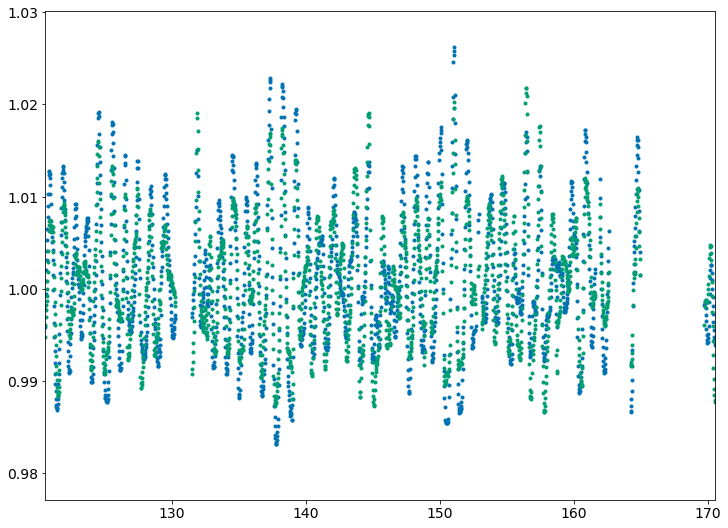

In [204]:
plt.plot(lc.time,lc.flux,'.')
plt.plot(lc.time,lc.flux-y_fit+1,'.')

plt.xlim(lc.time.min(),lc.time.min()+50)

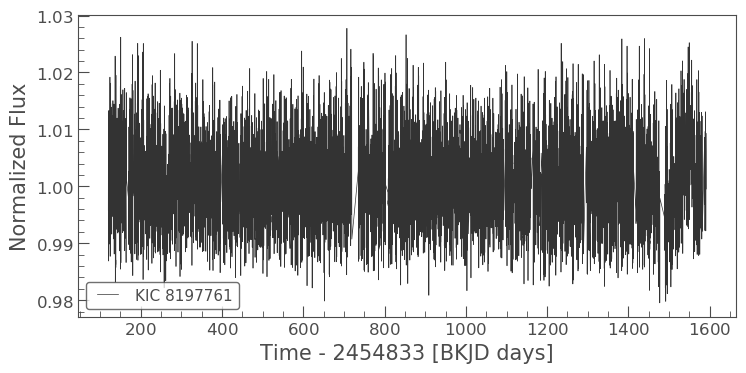

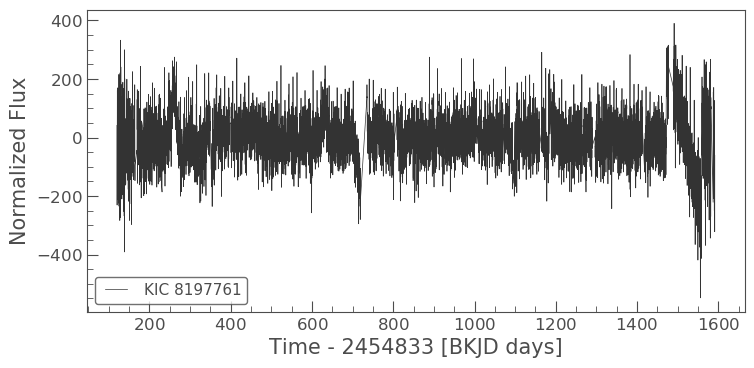

In [214]:
lc = lcs[0]
for lci in lcs[1:]:
    lc = lc.append(lci)
lc.plot()

lc2 = copy.copy(lc)
ff, pp, noise = [], [], []
y_fit = 0

for j in range(60):
    pg = lc2.to_periodogram(min_period=4./24.*u.day, max_period=30.*u.day)
    ff.append(pg.frequency_at_max_power.value)
    pp.append(pg.max_power.value)
    y_fit += LombScargle(lc2.time, lc2.flux, lc2.flux_err).model(lc2.time, pg.frequency_at_max_power.value)
    lc2.flux = lc.flux- y_fit + 1.
    noise.append(lc2.estimate_cdpp())
    
lc2.plot()

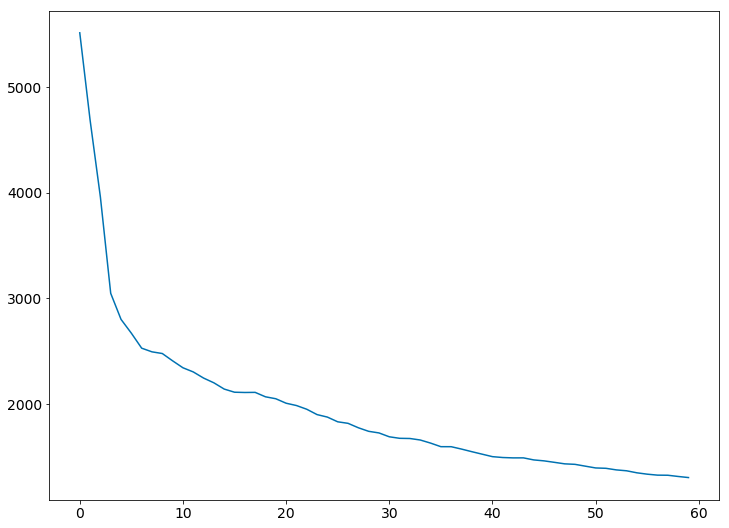

In [213]:
plt.plot(noise)

(500, 900)

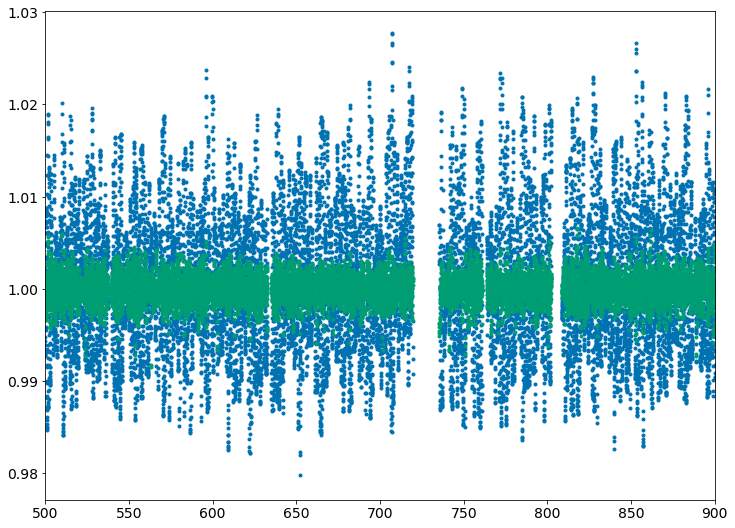

In [206]:
lc2=lc2.flatten()
plt.plot(lc.time,lc.flux,'.')
plt.plot(lc.time,lc2.flux,'.')

plt.xlim(500,900)

In [207]:
planet_period = 9.8686667
folded = lc.fold(planet_period)
binned = folded.bin(binsize=25,method='median')

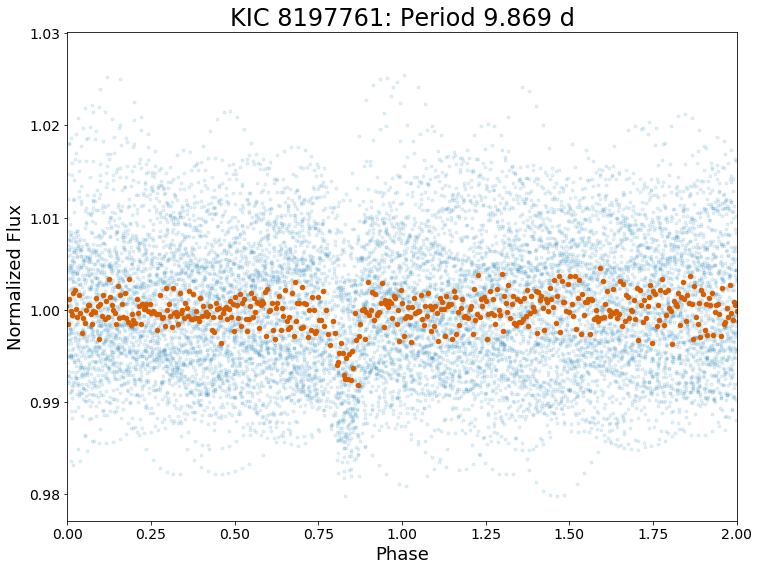

In [208]:
plt.plot(folded.phase*planet_period,folded.flux,'.',alpha=0.1)
plt.plot(binned.phase*planet_period,binned.flux,'.',markersize=9,color=colours[2])
plt.xlim(0,2)
plt.xlabel('Phase')
plt.ylabel('Normalized Flux')
plt.title('KIC %d: Period %.3f d' % (lc.targetid,planet_period))
plt.savefig('oscillator_with_planets.png')

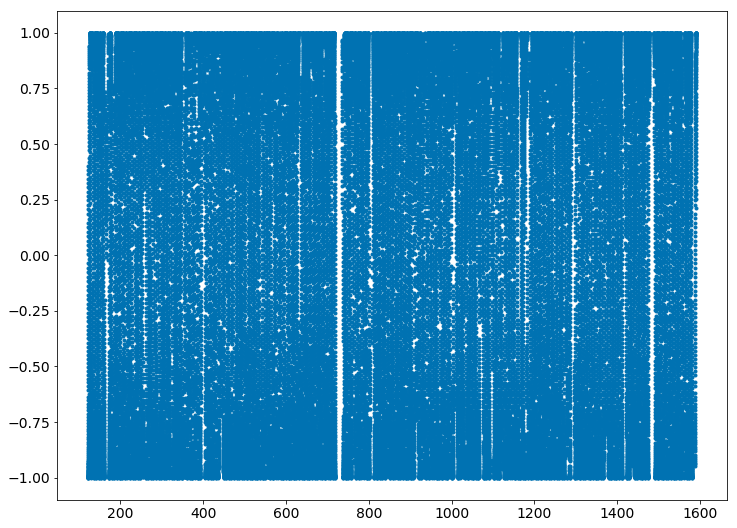

In [191]:
dummy = np.cos(lc.time)
toy = LombScargle(lc.time, dummy, lc.flux_err)
frequency, power = toy.autopower(minimum_frequency=0.1,\
                                                   maximum_frequency=1.9,\
                                                   samples_per_peak=10)
plt.plot(lc.time,dummy,'.')
best_frequency = frequency[np.argmax(power)]
test = toy.model(lc.time, best_frequency)


In [148]:
test = toy.model(lc.time, best_frequency)

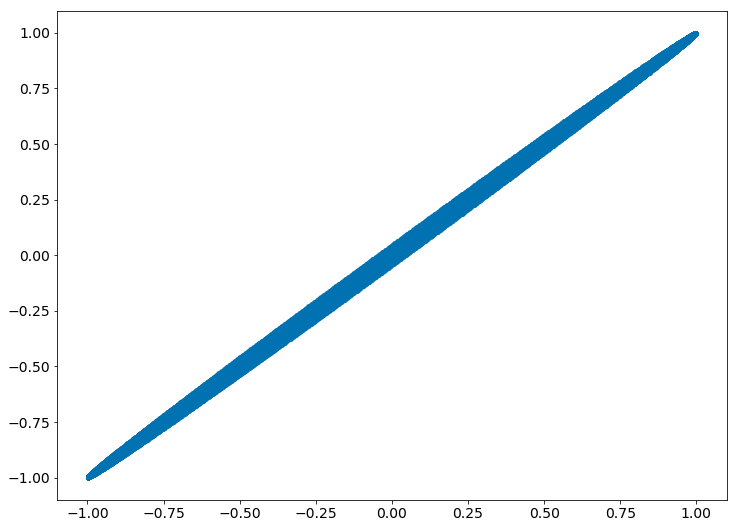

In [149]:
plt.plot(test,dummy,'.')

In [210]:
cdpp.cdpp(lc.time,lc.flux)

6552.293270360025

## Now do a BLS search to find it

In [215]:
from pybls import BLS


In [264]:
bls = BLS(lc2.time, lc2.flux, lc2.flux_err/10., period_range=(1,40), q_range=(0.001, 0.01), nf=4500, nbin=2000)


In [265]:
res = bls()

TypeError: range() integer end argument expected, got numpy.float64.

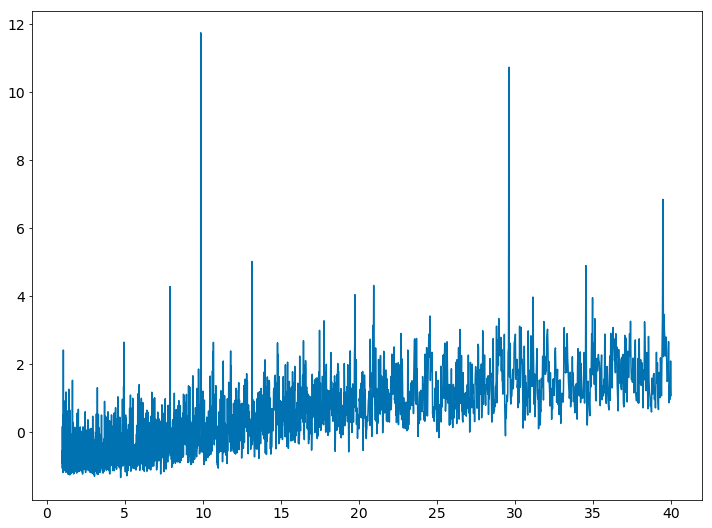

In [272]:
plt.plot(bls.period,bls.sde)
for j in range(bls.period.max()/res.bper):
    plt.axvline(res.bper*j,alpha=0.25,color=colours[2])
plt.text(res.bper*1.05,bls.sde.max()*0.95,'%.2f d' % res.bper)
plt.xlabel('Period (d)')
plt.ylabel('BLS Statistic')
plt.title('BLS Transit Search',y=1.01)

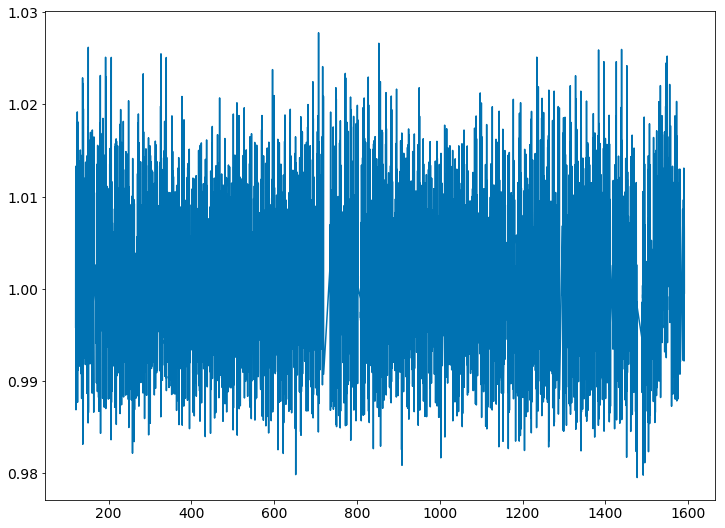

In [231]:
plt.plot(lc.time, lc.flux)